 В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
В папке train_images содержатся изображения для тренировки модели.
В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.
В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов. 
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      
В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
В папке test_images содержатся изображения для тестирования модели.
При решении задачи используйте только один фреймворк  Pytorch или Keras.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

In [1]:
import os
import re
import sys
import pickle
from collections import Counter
from os.path import exists, isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ipywidgets import IntProgress
from tqdm.notebook import tqdm, trange

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from nltk.corpus import stopwords as nltk_stopwords
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from functools import lru_cache

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
Path= 'C:/Users/PC/Downloads/to_upload'

In [3]:
train_dataset = pd.read_csv(os.path.join(Path, 'train_dataset.csv'))
crowd_annotations = pd.read_csv(os.path.join(Path, 'CrowdAnnotations.tsv'),names=(['picture','query_id',
                                                                                                  'people_perc',
                                                                                                  'correspondence',
                                                                                                   'inconsistency']), sep='\t')
expert_annotations = pd.read_csv(os.path.join(Path,'ExpertAnnotations.tsv'), names=(['picture','query_id',
                                                                                                     'first_expert',
                                                                                                     'second_expert',
                                                                                                     'third_expert']), 
                                                                                                      sep='\t')
test_queries = pd.read_csv(os.path.join(Path, 'test_queries.csv'), sep='|', index_col=0)
test_images = pd.read_csv(os.path.join(Path, 'test_images.csv'))

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
train_dataset.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


In [6]:
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Имеется 3 столбца (image, query_id, query_text: изображение, id, текст).

In [7]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [8]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


In [9]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


Имеется 3 столбца (image, query_id, query_text: изображение, id, текст).

In [10]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [11]:
test_images.describe()

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


In [12]:
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


Имеется информация об изображениях.

In [13]:
crowd_annotations.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   picture         47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   people_perc     47830 non-null  float64
 3   correspondence  47830 non-null  int64  
 4   inconsistency   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [14]:
crowd_annotations.describe()

,people_perc,correspondence,inconsistency
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


In [15]:
crowd_annotations.head()

,picture,query_id,people_perc,correspondence,inconsistency
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


В файле содержится следующая информация: 

картинка, 

id, 

доля исполнителей, подтвердивших, что текст соответствует картинке.

количество исполнителей, подтвердивших, что текст соответствует картинке.

количество исполнителей, подтвердивших, что текст не соответствует картинке.

In [16]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   picture        5822 non-null   object
 1   query_id       5822 non-null   object
 2   first_expert   5822 non-null   int64 
 3   second_expert  5822 non-null   int64 
 4   third_expert   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [17]:
expert_annotations.describe()

,first_expert,second_expert,third_expert
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


In [18]:
expert_annotations.head()

,picture,query_id,first_expert,second_expert,third_expert
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


В файле содержится информация: картинка, id, первый эксперт, второй эксперт, третий эксперт

1. В train dataset содержится информация для обучения модели.
2. В test_queries - информация для тестирования модели
3. В test_images - изображения для тестирования модели
4. В crowd_annotations - информация о том, соответствует ли описание изображению.
5. В expert_annotations - данные о соответствии изображения и описания.


## 1.1 Соединение датасетов

Выполняю агрегацию оценок, усреднив оценки экспертов.

In [19]:
expert_annotations['expert_annotation'] = (expert_annotations[['first_expert', 'second_expert', 'third_expert']].mean(axis=1) - 1) / 3

In [20]:
expert_annotations = expert_annotations.drop(['first_expert', 'second_expert', 'third_expert'], axis=1)
crowd_annotations = crowd_annotations.drop(['correspondence', 'inconsistency'], axis=1)

In [21]:
data_merged = pd.merge(expert_annotations, crowd_annotations, on=['picture', 'query_id'], how='left')

In [22]:
def calculate_score(row):
    if pd.notna(row['expert_annotation']) and pd.notna(row['people_perc']):
        return 0.6 * row['expert_annotation'] + 0.4 * row['people_perc']
    elif pd.notna(row['expert_annotation']):
        return row['expert_annotation'] * 0.6
    elif pd.notna(row['people_perc']):
        return row['people_perc'] * 0.4
    else:
        return np.nan

In [23]:
data_merged['score'] = data_merged.apply(calculate_score, axis=1)

In [24]:
data_merged = data_merged.drop(['expert_annotation', 'people_perc'], axis=1)

In [25]:
unique_queries = train_dataset[['query_id', 'query_text']].drop_duplicates()
data_merged = data_merged.merge(unique_queries, on='query_id')

In [26]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   picture     5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   score       5822 non-null   float64
 3   query_text  5822 non-null   object 
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


In [27]:
data_merged.head()

,picture,query_id,score,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,A young child is wearing blue goggles and sitt...
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.066667,A girl wearing a yellow shirt and sunglasses s...
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.066667,A man sleeps under a blanket on a city street .
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.133333,A woman plays with long red ribbons in an empt...
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.066667,Chinese market street in the winter time .


Агрегация оценок проведена успешно.

Произведено объединение датафреймов: оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4. Если есть только одна оценка, то используется она.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [28]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
def for_text_clear(text):    
    stop_words = set(nltk_stopwords.words('english'))
    text = text.lower()
    word_list = re.sub(r"[^a-z ]", ' ', text).split()
    word_notstop_list = [w for w in word_list if not w in stop_words]
    return ' '.join(word_notstop_list)

In [30]:
data_merged ['query_text'] = data_merged['query_text'].apply(for_text_clear)

In [31]:
def word_clear_2(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [32]:
def lemm_text(text):        
    word_list = text.split()
    lemmatized_text = ' '.join([WordNetLemmatizer().lemmatize(w, word_clear_2(w)) for w in word_list])
    return lemmatized_text

In [33]:
data_merged ['query_text'] = data_merged['query_text'].apply(lemm_text)

In [34]:
black_list= ['child', 'children', 'baby', 'babies', 'boy', 'boys', 'girl', 'girls', 'kid','kids','infant','teenager','youth','newborn', 'schoolboy']

In [35]:
def remove_banwords(df, black_list):
    mask = df['query_text'].apply(lambda query_text: not any(banned_word in query_text for banned_word in black_list) if isinstance(query_text, str) else True)
    
    filtered_df = df[mask]
    
    return filtered_df

In [36]:
data_merged = remove_banwords(data_merged, black_list)

In [37]:
data_merged.head(15)

,picture,query_id,score,query_text
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.066667,man sleep blanket city street
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.133333,woman play long red ribbon empty square
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.066667,chinese market street winter time
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,soccer ball head man wear black short red blac...
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,man woman look back camera stand front red art...
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,0.000000,white dog jump catch blue ball living room
11,106490881_5a2dd9b7bd.jpg,2398605966_1d0c9e6a20.jpg#2,0.000000,two long haired puppy dog romp snow
13,106490881_5a2dd9b7bd.jpg,3119076670_64b5340530.jpg#2,0.000000,snowboarder air perform stunt
14,106490881_5a2dd9b7bd.jpg,317488612_70ac35493b.jpg#2,0.000000,dog run deep snow
15,106490881_5a2dd9b7bd.jpg,493621130_152bdd4e91.jpg#2,0.000000,dog wear collar jumping platform


In [38]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 2 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   picture     4254 non-null   object 
 1   query_id    4254 non-null   object 
 2   score       4254 non-null   float64
 3   query_text  4254 non-null   object 
dtypes: float64(1), object(3)
memory usage: 166.2+ KB


In [39]:
data_merged.drop_duplicates(subset=['picture', 'query_id', 'score', 'query_text'], inplace=True)

In [40]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4254 entries, 2 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   picture     4254 non-null   object 
 1   query_id    4254 non-null   object 
 2   score       4254 non-null   float64
 3   query_text  4254 non-null   object 
dtypes: float64(1), object(3)
memory usage: 166.2+ KB


In [41]:
data_merged.head()

,picture,query_id,score,query_text
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.066667,man sleep blanket city street
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.133333,woman play long red ribbon empty square
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.066667,chinese market street winter time
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,soccer ball head man wear black short red blac...
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,man woman look back camera stand front red art...


1. Сделано объединение данных по столбцу query_id.

2. Удаляется столбец image, так как он дублируется.

3. Функция for_text_clear очищает текст, удаляет все символы кроме букв и пробелов, применяет текст к нижнему регистру и удаляет стоп-слова.

4. Функция word_clear_2 определяет часть речи для каждого слова для корректной лемматизации.

5. Функция remove_banwords удаляет строки, содержащие слова из черного списка.

После первой попытки векторизации поняла, что что-то не то с данными, поскольку компьютер не обрабатывал. Решила проверить на дубликаты и избавиться от них.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [42]:
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad_(False)

c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [44]:
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [45]:
@lru_cache(maxsize=None)
def vector_made(image_name):
    img_path = os.path.join(Path, 'train_images', image_name)
    img = Image.open(img_path).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    return output_tensor.numpy()

In [46]:
data_train = data_merged.copy()
image_train_vectors = np.array(data_merged['picture'].apply(vector_made).tolist())

In [47]:
print(image_train_vectors.shape)

(4254, 2048)


In [48]:
display (image_train_vectors)

array([[0.02304273, 0.9208461 , 0.03865051, ..., 0.13603126, 0.1750291 ,
        0.25570455],
       [0.02304273, 0.9208461 , 0.03865051, ..., 0.13603126, 0.1750291 ,
        0.25570455],
       [0.02304273, 0.9208461 , 0.03865051, ..., 0.13603126, 0.1750291 ,
        0.25570455],
       ...,
       [0.22283484, 0.60439336, 0.32670456, ..., 0.31483674, 0.6263066 ,
        0.07119307],
       [0.22283484, 0.60439336, 0.32670456, ..., 0.31483674, 0.6263066 ,
        0.07119307],
       [0.22283484, 0.60439336, 0.32670456, ..., 0.31483674, 0.6263066 ,
        0.07119307]], dtype=float32)

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [49]:
data_train.head(15)

,picture,query_id,score,query_text
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.066667,man sleep blanket city street
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.133333,woman play long red ribbon empty square
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.066667,chinese market street winter time
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000,soccer ball head man wear black short red blac...
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,man woman look back camera stand front red art...
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,0.000000,white dog jump catch blue ball living room
11,106490881_5a2dd9b7bd.jpg,2398605966_1d0c9e6a20.jpg#2,0.000000,two long haired puppy dog romp snow
13,106490881_5a2dd9b7bd.jpg,3119076670_64b5340530.jpg#2,0.000000,snowboarder air perform stunt
14,106490881_5a2dd9b7bd.jpg,317488612_70ac35493b.jpg#2,0.000000,dog run deep snow
15,106490881_5a2dd9b7bd.jpg,493621130_152bdd4e91.jpg#2,0.000000,dog wear collar jumping platform


In [50]:
stopwords = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_value = data_train['query_text'].values
text_tf_idf = count_tf_idf.fit_transform(train_value)
txt_tf_idf = text_tf_idf.toarray()

In [51]:
print(txt_tf_idf.shape)

(4254, 940)


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [52]:
assert image_train_vectors.shape[0] == txt_tf_idf.shape[0]

In [53]:
features = np.hstack([image_train_vectors, txt_tf_idf])

In [54]:
target = np.array(data_train['score'])

In [55]:
print("Объединенные признаки", features)

Объединенные признаки [[0.02304273 0.9208461  0.03865051 ... 0.         0.         0.        ]
 [0.02304273 0.9208461  0.03865051 ... 0.         0.         0.        ]
 [0.02304273 0.9208461  0.03865051 ... 0.         0.         0.        ]
 ...
 [0.22283484 0.60439336 0.32670456 ... 0.         0.         0.        ]
 [0.22283484 0.60439336 0.32670456 ... 0.         0.         0.        ]
 [0.22283484 0.60439336 0.32670456 ... 0.         0.         0.        ]]


In [56]:
print("Целевая переменная", target)

Целевая переменная [0.06666667 0.13333333 0.06666667 ... 0.06666667 0.         0.53333333]


In [57]:
print(features.shape)

(4254, 2988)


In [58]:
print(target.shape)

(4254,)


Сделано объединение векторов, разделение на целевую переменную и признаки.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [59]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, valid_indices = next(gss.split(X=features, y=data_merged['score'], groups=data_merged['picture']))

In [60]:
features_train = features[train_indices]
features_valid = features[valid_indices]
target_train = target[train_indices]
target_valid = target[valid_indices]

In [61]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

In [62]:
def train_and_evaluate(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(target_valid, predictions)
    return rmse, r2

In [63]:
models = {
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=30,
        max_depth=5,
        min_samples_split=2,
        random_state=42
    ),
    'LinearRegression': LinearRegression(),
}

results = {}

In [64]:
for model_name, model in models.items():
    rmse, r2 = train_and_evaluate(model, features_train, target_train, features_valid, target_valid)
    results[model_name] = (rmse, r2, model.get_params())

In [65]:
for model_name, (rmse, r2, params) in results.items():
    print(f"{model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

RandomForestRegressor:
  RMSE: 0.2240
  R²: 0.1650
LinearRegression:
  RMSE: 2854141093952.8794
  R²: -135519680839625257487695872.0000


In [66]:
best_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=100,
    random_state=42
)
best_model.fit(features_train, target_train)

predictions_valid = best_model.predict(features_valid)

mse_valid = mean_squared_error(target_valid, predictions_valid)
rmse_valid = np.sqrt(mse_valid)
r2_valid = r2_score(target_valid, predictions_valid)
print(f"  RMSE (Validation): {rmse_valid:.4f}")
print(f"  R² (Validation): {r2_valid:.4f}")


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522215
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 2229
[LightGBM] [Info] Start training from score 0.177206
  RMSE (Validation): 0.2150
  R² (Validation): 0.2311


## 6.1 Нейронная сеть

In [67]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [68]:
input_size = features_train.shape[1]
model = SimpleNN(input_size)

In [69]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32).view(-1, 1)
features_valid_tensor = torch.tensor(features_valid, dtype=torch.float32)
target_valid_tensor = torch.tensor(target_valid, dtype=torch.float32).view(-1, 1)

In [71]:
train_dataset = TensorDataset(features_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [72]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features_batch, target_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(features_batch)
        loss = criterion(outputs, target_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    running_loss /= len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')

Epoch [1/50], Loss: 0.0761
Epoch [2/50], Loss: 0.0476
Epoch [3/50], Loss: 0.0370
Epoch [4/50], Loss: 0.0286
Epoch [5/50], Loss: 0.0228
Epoch [6/50], Loss: 0.0187
Epoch [7/50], Loss: 0.0149
Epoch [8/50], Loss: 0.0136
Epoch [9/50], Loss: 0.0115
Epoch [10/50], Loss: 0.0115
Epoch [11/50], Loss: 0.0095
Epoch [12/50], Loss: 0.0074
Epoch [13/50], Loss: 0.0068
Epoch [14/50], Loss: 0.0081
Epoch [15/50], Loss: 0.0068
Epoch [16/50], Loss: 0.0059
Epoch [17/50], Loss: 0.0055
Epoch [18/50], Loss: 0.0050
Epoch [19/50], Loss: 0.0050
Epoch [20/50], Loss: 0.0043
Epoch [21/50], Loss: 0.0044
Epoch [22/50], Loss: 0.0038
Epoch [23/50], Loss: 0.0039
Epoch [24/50], Loss: 0.0031
Epoch [25/50], Loss: 0.0028
Epoch [26/50], Loss: 0.0029
Epoch [27/50], Loss: 0.0031
Epoch [28/50], Loss: 0.0037
Epoch [29/50], Loss: 0.0033
Epoch [30/50], Loss: 0.0028
Epoch [31/50], Loss: 0.0031
Epoch [32/50], Loss: 0.0034
Epoch [33/50], Loss: 0.0037
Epoch [34/50], Loss: 0.0038
Epoch [35/50], Loss: 0.0035
Epoch [36/50], Loss: 0.0034
E

In [73]:
model.eval()
with torch.no_grad():
    predictions_valid = model(features_valid_tensor).flatten()
    mse_valid = mean_squared_error(target_valid_tensor, predictions_valid)
    rmse_valid = np.sqrt(mse_valid)
    r2_valid = r2_score(target_valid_tensor, predictions_valid)
    print(f"  RMSE (Validation): {rmse_valid:.4f}")
    print(f"  R² (Validation): {r2_valid:.4f}")

  RMSE (Validation): 0.2221
  R² (Validation): 0.1796


Использую R (коэффициент детерминации, который измеряет, какая доля вариации целевой переменной объясняется моделью) и RMSE (корень из среднеквадратичной ошибки. Эта метрика измеряет средний квадрат ошибок предсказаний модели).

1. RandomForestRegressor:
RMSE: 0.2240
R²: 0.1650

2. LinearRegression:
RMSE: 2854141093952.8794
R²: -135519680839625257487695872.0000

3.  LightGBM:
RMSE (Validation): 0.2150
R² (Validation): 0.2311

4. Нейронная сеть:
RMSE (Validation): 0.2236
R² (Validation): 0.1686

LGBMRegressor - лучшая модель среди рассмотренных, так как она показала наименьшую ошибку предсказания и наибольшее значение коэффициента детерминации. Это показывает, что LGBMRegressor более точно предсказывает целевую переменную и лучше объясняет ее вариацию по сравнению с RandomForestRegressor и LinearRegression.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [74]:
def pic_vector_test(row):
    img_path = os.path.join(path_test, row['image'])
    img = Image.open(img_path).convert('RGB')
    image_tensor = preprocess(img)
    output_tensor = resnet(image_tensor.unsqueeze(0)).flatten()
    return output_tensor.numpy()

path_test = os.path.join(Path, 'test_images')
image_test_vectors = np.vstack(np.array(test_images.apply(pic_vector_test, axis=1)))

In [75]:
def img_test(text):
    print(f'Описание: {text}')
    for word in text.split():
        if word in black_list:
            return print('WARNING: This image is unavailable in your country in compliance with local laws.')

    text_vector = count_tf_idf.transform([text]).toarray()
    best_score = 0
    best_index = -1

    for i in range(len(image_test_vectors)):
        combined_features = np.hstack((image_test_vectors[i], text_vector.flatten()))
        scaled_features = scaler.transform([combined_features])
        score = best_model.predict(scaled_features)

        if score > best_score:
            best_score = score
            best_index = i

    if best_index == -1:
        print("No suitable image found.")
    else:
        print(f'Best Probability: {best_score}')
        print(f'Best index: {best_index}')
        print(f'Best Image:')
        img_path = os.path.join(path_test, test_images.iloc[best_index]['image'])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()


Описание: A group of girls who are gothically dressed standing together
Описание: A woman and girl riding downhill on a sled with a dog running alongside them
Описание: The dog is running .
Best Probability: [0.55081082]
Best index: 40
Best Image:


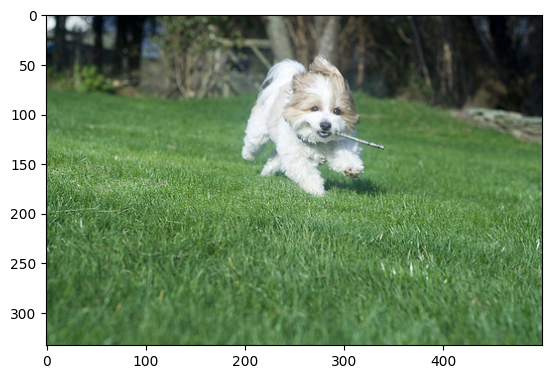

Описание: A group of people are ice skating in a big city .
Best Probability: [0.43767554]
Best index: 64
Best Image:


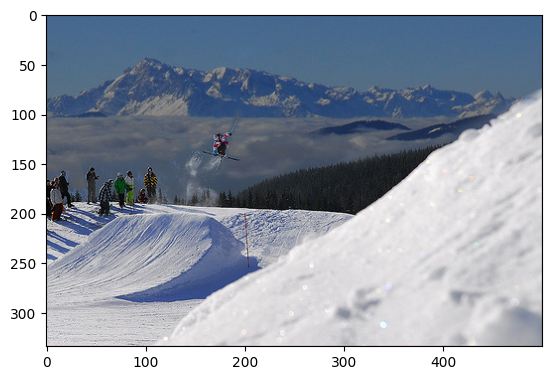

Описание: Little kid in blue coat and hat riding a tricycle .
Описание: Two black dogs fighting over an orange toy .
Best Probability: [0.39165625]
Best index: 64
Best Image:


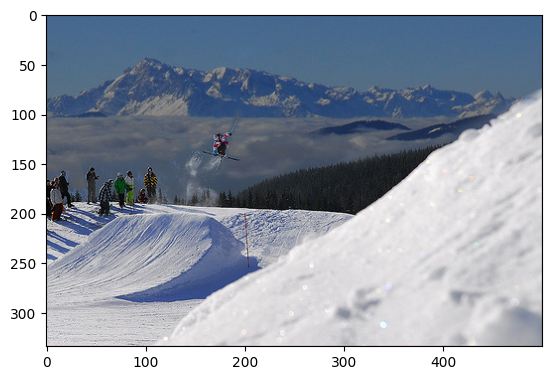

Описание: A dog jumping for a tennis ball near an ocean
Best Probability: [0.43447169]
Best index: 40
Best Image:


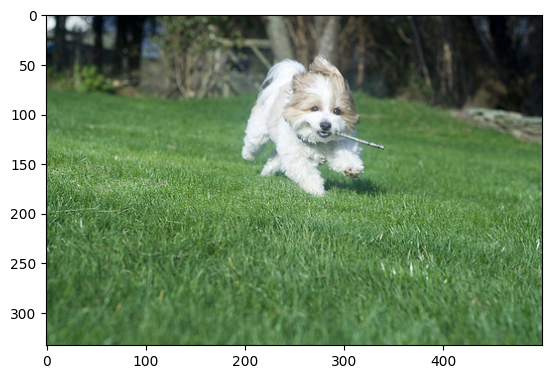

Описание: Boy flying a distant kite .
Best Probability: [0.40686483]
Best index: 64
Best Image:


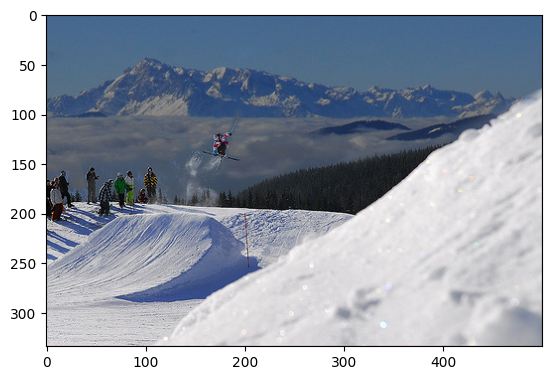

Описание: kids play ultimate Frisbee .
Описание: A girl in a purple shirt feeding ducks


In [76]:
best_model_test = test_queries['query_text'].sample(10, random_state=42)
for query in best_model_test:
    img_test(query)

Проделана работа по проверке модели на тестовых данных. Далее была реализована модель,если какое-то изображение запрещено для показа по закону, то выводится соответствующий текст, как было показано в образце. Модель работает не слишком идеально, но совпадающие картинки есть. 